In [1]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt

from diffbank.noise import Sn_aLIGO as Sn

from pycbc.types import FrequencySeries
from pycbc.filter.matchedfilter import match

In [2]:
# Override get_effectualness so we can fiddle with it

# from diffbank.utils import get_effectualness

def get_overlap_tc(wf1, wf2, Sns):
    norm1 = jnp.sqrt(4.0 * jnp.sum(jnp.abs(wf1)**2 / Sns))
    norm2 = jnp.sqrt(4.0 * jnp.sum(jnp.abs(wf2)**2 / Sns))
    norm = norm1 * norm2
    return jnp.fft.fft(4.0 * wf1 * wf2.conj() / Sns) / norm


def get_eff_new(wf1, wf2, Sns):
    return jnp.abs(get_overlap_tc(wf1, wf2, Sns)).max()

## 3PN
Issue doesn't seem quite as severe...

In [3]:
from diffbank.utils import get_effectualness
from diffbank.waveforms.threePN_simple import amp, Psi

In [4]:
key = random.PRNGKey(1)

# Frequency grid
df = 0.0125
f_high = 512.0
n_f = int(f_high / df) + 1
fs = jnp.linspace(0, f_high, n_f)
f_low = 8.0
idx_low = jnp.where(fs == f_low)[0][0]

match_dbs = []
match_pycbcs = []

for _ in range(20):
    # Set parameters
    key, M1_key, M2_key, eta1_key, eta2_key = random.split(key, 5)
    M1 = random.uniform(M1_key, minval=2.0, maxval=10.0)
    M2 = random.uniform(M2_key, minval=M1 - 0.0001, maxval=M1 + 0.0001)
    eta1 = random.uniform(eta1_key, minval=0.2, maxval=0.25)
    eta2 = random.uniform(
        eta2_key, minval=eta1 - 0.0005, maxval=min(0.25, eta1 + 0.0005)
    )
    theta1 = jnp.array([M1, eta1])
    theta2 = jnp.array([M2, eta2])

    # diffbank
    match_db = get_effectualness(theta1, theta2, amp, Psi, fs[idx_low:], Sn)
    match_dbs.append(match_db)

    # pycbc
    wf1 = FrequencySeries(amp(fs, theta1) * jnp.exp(1j * Psi(fs, theta1)), df)
    wf2 = FrequencySeries(amp(fs, theta2) * jnp.exp(1j * Psi(fs, theta2)), df)
    psd = FrequencySeries(Sn(fs), df)
    match_pycbc = match(wf1, wf2, psd, f_low, f_high)[0]
    match_pycbcs.append(match_pycbc)

    print(f"{match_db:.5f}, {match_pycbc:.5f}")

match_dbs = jnp.array(match_dbs)
match_pycbcs = jnp.array(match_pycbcs)

0.97088, 0.97088
0.99580, 0.99580
0.99989, 0.99989
0.99914, 0.99914
0.73455, 0.73471
0.79415, 0.79896
0.97364, 0.97364
0.96971, 0.96971
0.99134, 0.99134
0.78061, 0.78167
0.97708, 0.97708
0.83757, 0.88584
0.99997, 0.99997
0.87829, 0.92885
0.98589, 0.98589
0.99992, 0.99992
0.99999, 0.99999
0.98913, 0.98913
0.97100, 0.97100
0.90706, 0.94039


Compare matches

Text(0.5, 1.0, '4D $\\kappa$ waveform')

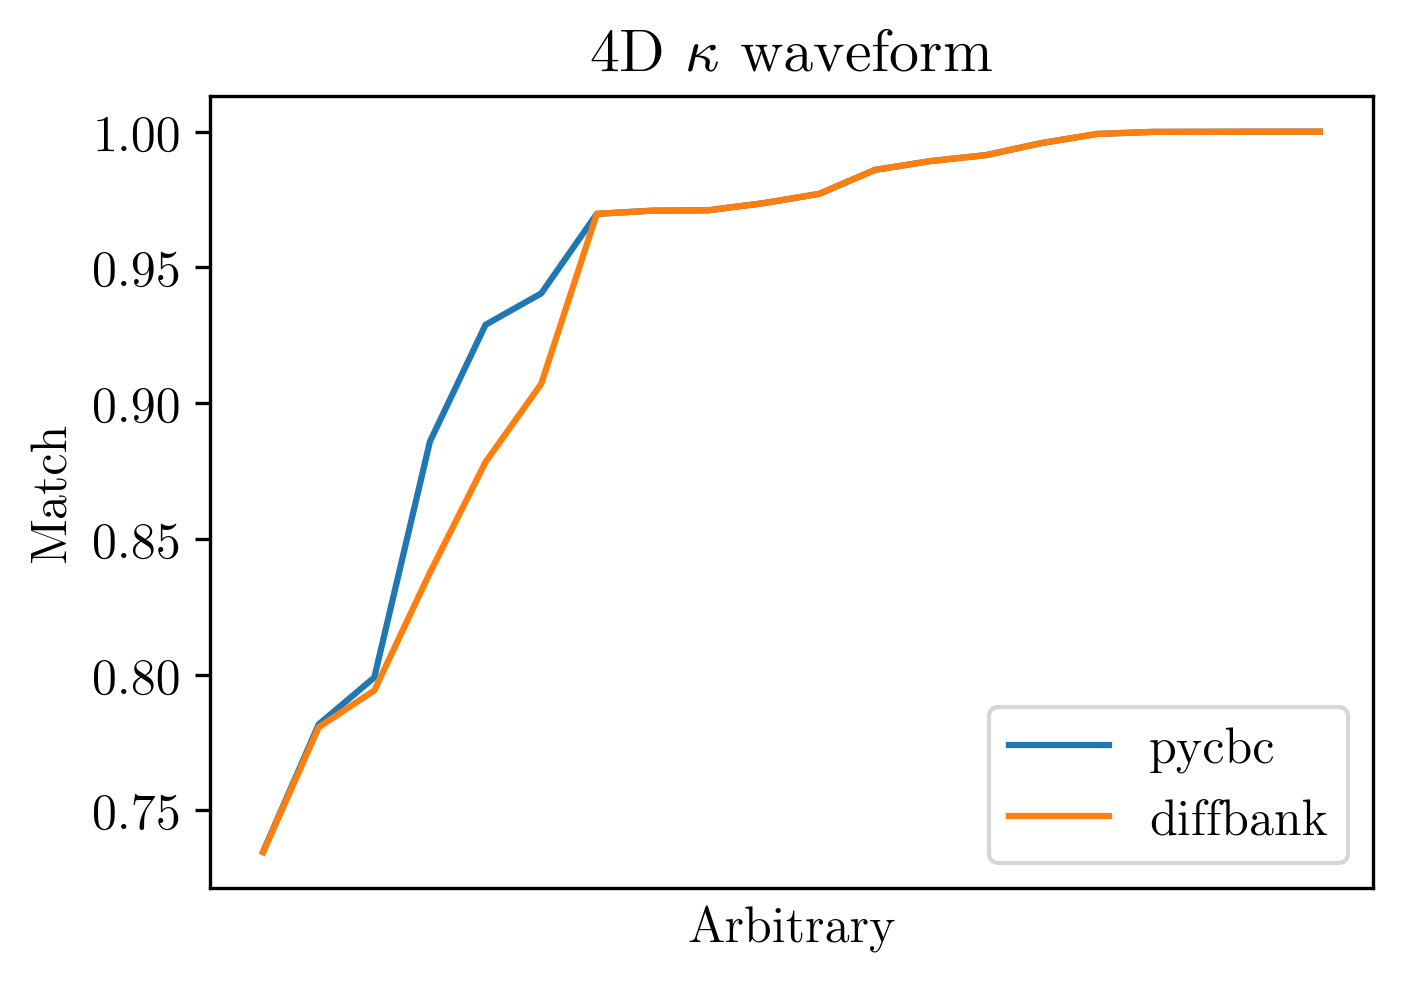

In [5]:
idxs = jnp.argsort(match_pycbcs)

plt.plot(match_pycbcs[idxs], label="pycbc")
plt.plot(match_dbs[idxs], label="diffbank")

plt.xticks([])
plt.xlabel("Arbitrary")
plt.ylabel("Match")
plt.legend()
plt.title(r"4D $\kappa$ waveform")

## $\kappa$
* Changing `df` makes no difference

In [6]:
from diffbank.waveforms.kappa4D import Amp as amp, Psi

# Change between real and constant noise model
from diffbank.noise import Sn_aLIGO as Sn
# def Sn(f):
#     return jnp.ones_like(f) * 1e-45

In [7]:
key = random.PRNGKey(9)

# Frequency grid
df = 0.0125
f_high = 512.0
n_f = int(f_high / df) + 1
fs = jnp.linspace(0, f_high, n_f)
f_low = 8.0
idx_low = jnp.where(fs == f_low)[0][0]

# Param ranges
m1_range = (1.001, 5.0)
m2_range = (1.0, 5.0)
chiz_range = (-0.6, 0.6)
kappa2PN_range = (0.0, 250.0)

match_dbs = []
match_pycbcs = []

for _ in range(14):
    # Set parameters
    key, m1_key, m2_key, chiz_key, kappa2PN_key, theta2_key = random.split(key, 6)
    m1 = random.uniform(m1_key, minval=m1_range[0], maxval=m1_range[1])
    m2 = random.uniform(m2_key, minval=m2_range[0], maxval=m2_range[1])
    chiz = random.uniform(chiz_key, minval=chiz_range[0], maxval=chiz_range[1])
    kappa2PN = random.uniform(
        kappa2PN_key, minval=kappa2PN_range[0], maxval=kappa2PN_range[1]
    )
    theta1 = jnp.array([m1, m2, chiz, kappa2PN])
    theta2 = theta1 + random.normal(theta2_key, theta1.shape) * 0.0012

    # Create waveforms
    wf1 = amp(fs, theta1) * jnp.exp(1j * Psi(fs, theta1))
    wf2 = amp(fs, theta2) * jnp.exp(1j * Psi(fs, theta2))
    Sns = Sn(fs)

    # diffbank
#     match_db = get_effectualness(theta1, theta2, amp, Psi, fs[idx_low:], Sn)
    match_db = get_eff_new(wf1[idx_low:], wf2[idx_low:], Sns[idx_low:])
    match_dbs.append(match_db)

    # pycbc
    psd = FrequencySeries(Sn(fs), df)
    match_pycbc = match(
        FrequencySeries(wf1, df), FrequencySeries(wf2, df), psd, f_low, f_high
    )[0]
    match_pycbcs.append(match_pycbc)

    print(f"{match_db:.5f}, {match_pycbc:.5f}")

match_dbs = jnp.array(match_dbs)
match_pycbcs = jnp.array(match_pycbcs)

0.91498, 0.93234
0.99994, 0.99994
0.97315, 0.97587
0.99450, 0.99450
0.99816, 0.99816
0.98762, 0.98762
0.99879, 0.99879
0.96590, 0.98111
0.88953, 0.93195
0.99533, 0.99533
0.97444, 0.97444
0.94336, 0.96742
0.97458, 0.97289
0.89981, 0.97464


Compare matches

Text(0.5, 1.0, '4D $\\kappa$ waveform')

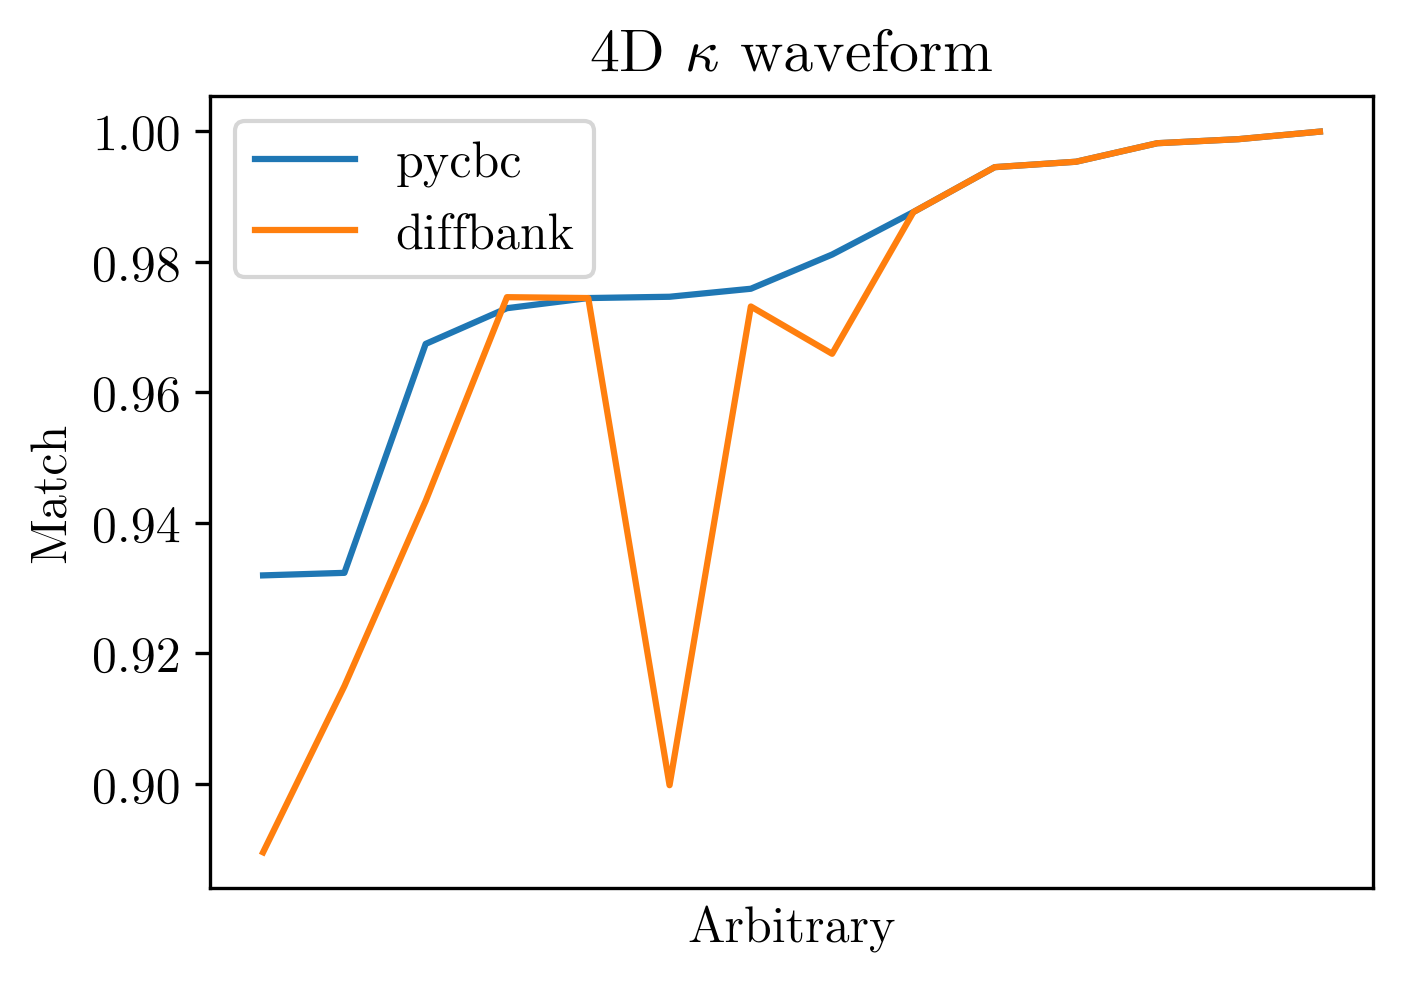

In [8]:
idxs = jnp.argsort(match_pycbcs)

plt.plot(match_pycbcs[idxs], label="pycbc")
plt.plot(match_dbs[idxs], label="diffbank")

plt.xticks([])
plt.xlabel("Arbitrary")
plt.ylabel("Match")
plt.legend()
plt.title(r"4D $\kappa$ waveform")

Directly looking at $t_c$ before maximization

(-1.0, 20.0)

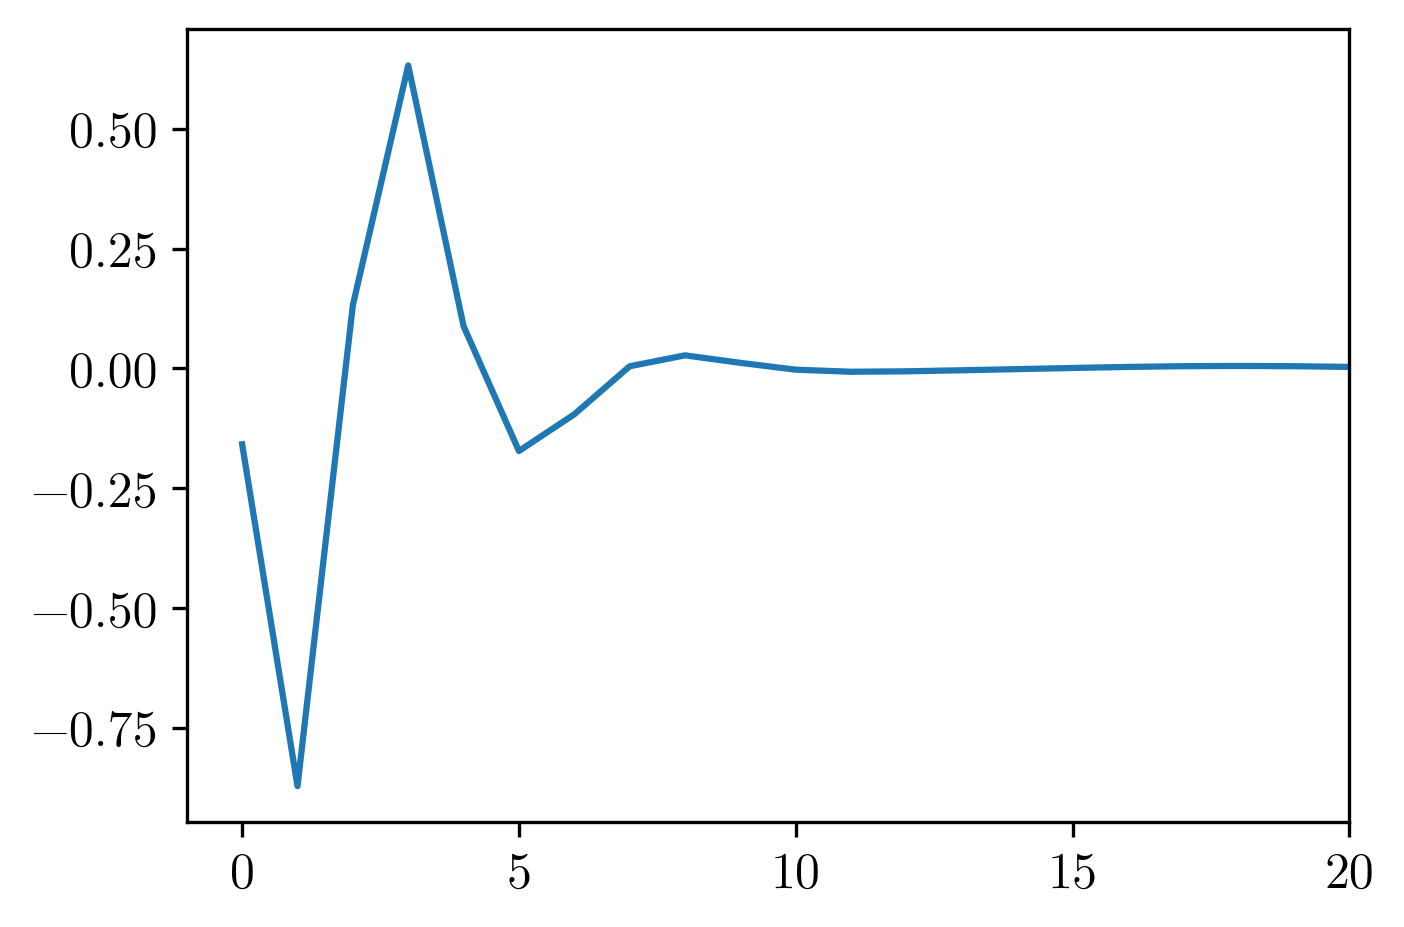

In [9]:
plt.plot(get_overlap_tc(wf1, wf2, Sns).real)
plt.xlim(-1, 20)
# plt.xlim(40000, 40325)